<a href="https://colab.research.google.com/github/JeelCueva/NOTAS_DE_CLASE_ECONOMETRIA_2/blob/master/econometria_notas_de_clase_cap3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CAPÍTULO 3: MODELOS CON VARIABLE DEPENDIENTE LIMITADA
Ejemplo 01: Modelos Probit y Logit

PARTE 1: CARGA Y PREPARACIÓN DE DATOS

Datos cargados: 9 observaciones

Primeras observaciones:
   AAPL_Return  NVDA_Return
0     0.009785     0.015969
1     0.022093    -0.066238
2    -0.047745    -0.034492
3     0.012073    -0.000016
4     0.035684     0.019832

---------------------------Estadísticas Descriptivas:---------------------------
Variable dependiente y (AAPL > 0):
  Proporción de éxitos (y=1): 0.6667
  Número de observaciones: 9
  Número de y=1: 6
  Número de y=0: 3

Variable independiente x (retorno NVDA):
  Media: -0.001479
  Desv. Estándar: 0.030132
  Mínimo: -0.066238
  Máximo: 0.029216

PARTE 2: ESTIMACIÓN MANUAL DEL MODELO PROBIT

Valores iniciales:
  β₀ inicial: 0.4307
  β₁ inicial: 0.0000

Maximizando la log-verosimilitud...

---------------------Resultados del Modelo Probit (Manual):---------------------
  β̂₀ (Intercepto): 0.4292
  β̂₁ (Pendiente):  -1.1792
  Log-verosimili

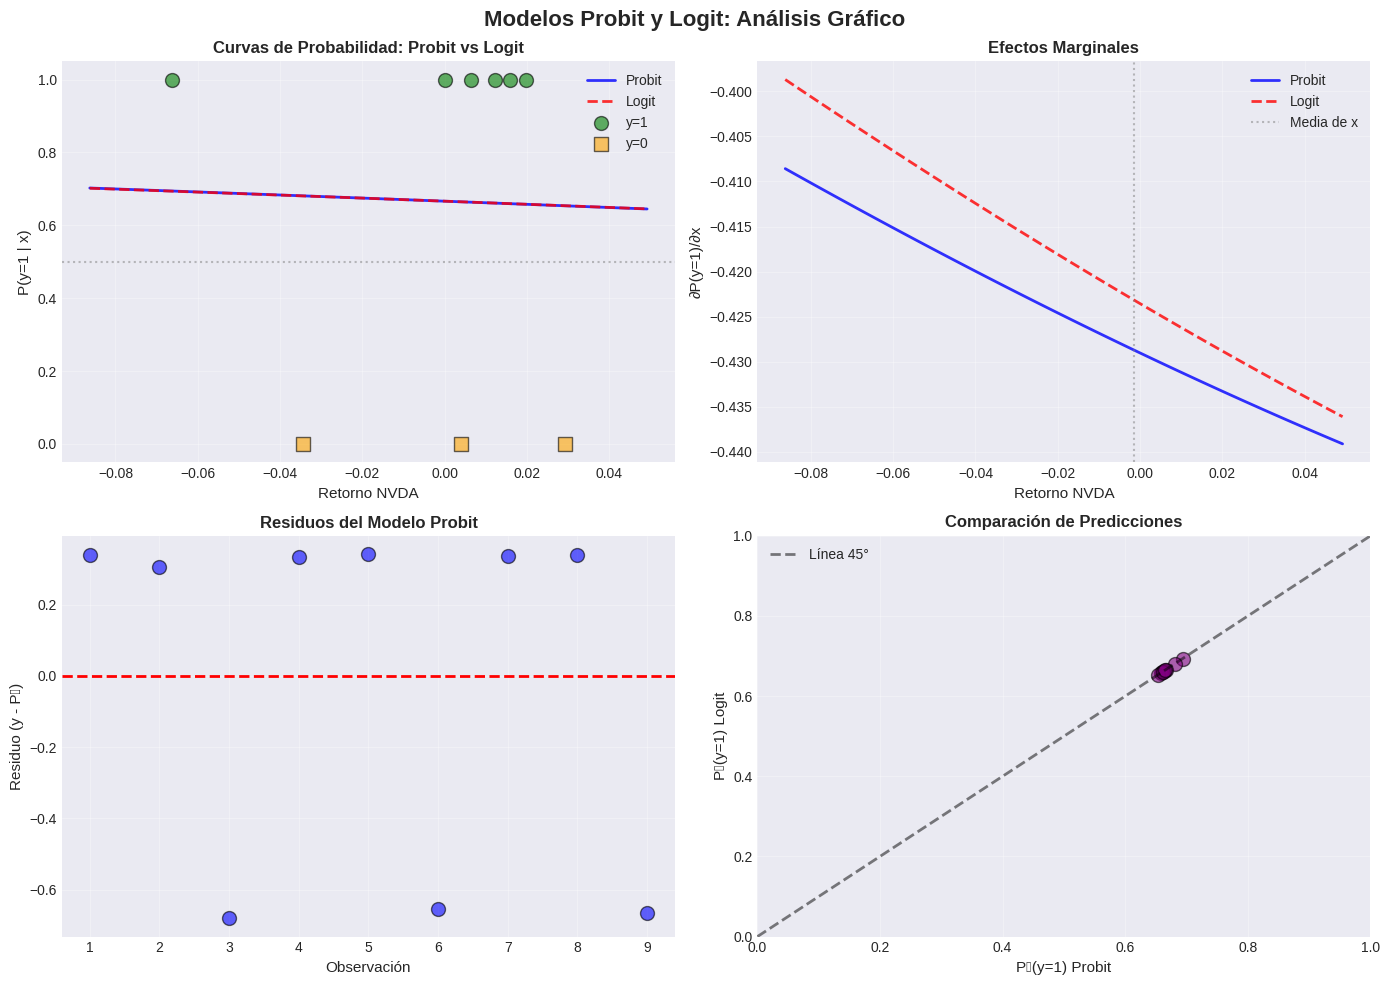


PARTE 9: ANÁLISIS CON MUESTRA COMPLETA

Muestra completa: 1260 observaciones
Proporción de y=1: 0.5294

------------------------Resultados con Muestra Completa:------------------------

Probit (n={len(y_completo)}):
         Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
const  0.07244  0.035396  2.046556  0.040702  0.003065  0.141814
x1     0.51065  0.776927  0.657269  0.511008 -1.012098  2.033398

Logit (n={len(y_completo)}):
          Coef.  Std.Err.         z     P>|z|    [0.025    0.975]
const  0.115639  0.056526  2.045777  0.040778  0.004851  0.226428
x1     0.816075  1.241143  0.657519  0.510847 -1.616520  3.248670

---------------------Efectos Marginales (Muestra Completa):---------------------

Probit:
       Probit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Capítulo 3: Modelos de Variable Dependiente Limitada
Ejemplo 01: Estimación de Modelos Probit y Logit

Este script implementa la estimación por máxima verosimilitud de modelos
de elección binaria (Probit y Logit) usando datos reales de retornos de acciones.

Author: [Tu nombre]
Date: 2024
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit, Logit
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficas
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("CAPÍTULO 3: MODELOS CON VARIABLE DEPENDIENTE LIMITADA")
print("Ejemplo 01: Modelos Probit y Logit")
print("="*80)

#%% ===========================================================================
# PARTE 1: CARGA Y PREPARACIÓN DE DATOS
# =============================================================================

print("\n" + "="*80)
print("PARTE 1: CARGA Y PREPARACIÓN DE DATOS")
print("="*80)

# Leer datos desde el Excel
file_path = '/content/datos_activos_financieros.xlsx'

# Leer muestra manual (10 observaciones)
df_manual = pd.read_excel(file_path, sheet_name='Muestra_Manual_10obs')

# Calcular retornos
df_manual['AAPL_Return'] = df_manual['AAPL'].pct_change()
df_manual['NVDA_Return'] = df_manual['NVDA'].pct_change()

# Eliminar primer valor (NaN)
df_manual = df_manual.dropna().reset_index(drop=True)

print(f"\nDatos cargados: {len(df_manual)} observaciones")
print(f"\nPrimeras observaciones:")
print(df_manual[['AAPL_Return', 'NVDA_Return']].head().round(6))

# Crear variable dependiente binaria: 1 si retorno de AAPL > 0
y = (df_manual['AAPL_Return'] > 0).astype(int).values
x = df_manual['NVDA_Return'].values
n = len(y)

print(f"\n{'Estadísticas Descriptivas:':-^80}")
print(f"Variable dependiente y (AAPL > 0):")
print(f"  Proporción de éxitos (y=1): {y.mean():.4f}")
print(f"  Número de observaciones: {n}")
print(f"  Número de y=1: {y.sum()}")
print(f"  Número de y=0: {n - y.sum()}")

print(f"\nVariable independiente x (retorno NVDA):")
print(f"  Media: {x.mean():.6f}")
print(f"  Desv. Estándar: {x.std(ddof=1):.6f}")
print(f"  Mínimo: {x.min():.6f}")
print(f"  Máximo: {x.max():.6f}")

#%% ===========================================================================
# PARTE 2: ESTIMACIÓN MANUAL DEL MODELO PROBIT
# =============================================================================

print("\n" + "="*80)
print("PARTE 2: ESTIMACIÓN MANUAL DEL MODELO PROBIT")
print("="*80)

def probit_log_likelihood(params, y, x):
    """
    Calcula la log-verosimilitud del modelo Probit

    Parameters:
    -----------
    params : array-like
        [beta_0, beta_1]
    y : array-like
        Variable dependiente binaria
    x : array-like
        Variable independiente

    Returns:
    --------
    float : Valor negativo de la log-verosimilitud (para minimización)
    """
    beta_0, beta_1 = params
    z = beta_0 + beta_1 * x

    # Probabilidad ajustada
    prob = norm.cdf(z)

    # Evitar log(0)
    prob = np.clip(prob, 1e-10, 1 - 1e-10)

    # Log-verosimilitud
    log_lik = np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))

    return -log_lik  # Negativo para minimización

def probit_gradient(params, y, x):
    """Gradiente de la log-verosimilitud del Probit"""
    beta_0, beta_1 = params
    z = beta_0 + beta_1 * x

    prob = norm.cdf(z)
    pdf = norm.pdf(z)

    # Evitar división por cero
    prob = np.clip(prob, 1e-10, 1 - 1e-10)

    # Gradiente
    gradient = np.zeros(2)
    gradient[0] = -np.sum((y - prob) * pdf / (prob * (1 - prob)))
    gradient[1] = -np.sum((y - prob) * pdf * x / (prob * (1 - prob)))

    return gradient

# Valores iniciales
# beta_0 inicial: inverse normal CDF de la proporción de éxitos
beta_0_init = norm.ppf(y.mean())
beta_1_init = 0.0

params_init = np.array([beta_0_init, beta_1_init])

print(f"\nValores iniciales:")
print(f"  β₀ inicial: {beta_0_init:.4f}")
print(f"  β₁ inicial: {beta_1_init:.4f}")

# Maximización de la verosimilitud
print(f"\nMaximizando la log-verosimilitud...")
result_probit = minimize(
    probit_log_likelihood,
    params_init,
    args=(y, x),
    method='BFGS',
    jac=probit_gradient
)

beta_hat_probit = result_probit.x
print(f"\n{'Resultados del Modelo Probit (Manual):':-^80}")
print(f"  β̂₀ (Intercepto): {beta_hat_probit[0]:.4f}")
print(f"  β̂₁ (Pendiente):  {beta_hat_probit[1]:.4f}")
print(f"  Log-verosimilitud: {-result_probit.fun:.4f}")
print(f"  Convergencia: {'Exitosa' if result_probit.success else 'Fallida'}")

# Cálculo de la matriz de información de Fisher
def fisher_information_probit(params, y, x):
    """Calcula la matriz de información de Fisher"""
    beta_0, beta_1 = params
    z = beta_0 + beta_1 * x

    prob = norm.cdf(z)
    pdf = norm.pdf(z)

    # Evitar problemas numéricos
    prob = np.clip(prob, 1e-10, 1 - 1e-10)

    # Matriz de información
    info = np.zeros((2, 2))
    weight = (pdf ** 2) / (prob * (1 - prob))

    info[0, 0] = np.sum(weight)
    info[0, 1] = np.sum(weight * x)
    info[1, 0] = info[0, 1]
    info[1, 1] = np.sum(weight * x ** 2)

    return info

# Matriz de información
info_matrix = fisher_information_probit(beta_hat_probit, y, x)
var_cov_matrix = np.linalg.inv(info_matrix)
se_probit = np.sqrt(np.diag(var_cov_matrix))

print(f"\n{'Errores Estándar y Pruebas de Hipótesis:':-^80}")
print(f"  SE(β̂₀): {se_probit[0]:.4f}")
print(f"  SE(β̂₁): {se_probit[1]:.4f}")

# Estadísticos z
z_stats = beta_hat_probit / se_probit
p_values = 2 * (1 - norm.cdf(np.abs(z_stats)))

print(f"\n  Estadístico z para β₀: {z_stats[0]:.3f} (p-valor: {p_values[0]:.3f})")
print(f"  Estadístico z para β₁: {z_stats[1]:.3f} (p-valor: {p_values[1]:.3f})")

# Interpretación
print(f"\n{'Interpretación:':-^80}")
prob_at_zero = norm.cdf(beta_hat_probit[0])
print(f"  Cuando x=0, P(y=1) = Φ({beta_hat_probit[0]:.4f}) = {prob_at_zero:.4f}")
print(f"  Un aumento de 1 unidad en x aumenta la probabilidad")
print(f"  (el efecto marginal depende del valor de x)")

#%% ===========================================================================
# PARTE 3: CÁLCULO DE PROBABILIDADES AJUSTADAS Y CLASIFICACIÓN
# =============================================================================

print("\n" + "="*80)
print("PARTE 3: PROBABILIDADES AJUSTADAS Y CLASIFICACIÓN")
print("="*80)

# Calcular probabilidades ajustadas
z_fitted = beta_hat_probit[0] + beta_hat_probit[1] * x
prob_fitted = norm.cdf(z_fitted)
y_pred = (prob_fitted > 0.5).astype(int)

# Tabla de resultados
results_df = pd.DataFrame({
    'Obs': range(1, n + 1),
    'y': y,
    'x': x,
    'z = β₀ + β₁x': z_fitted,
    'P̂(y=1)': prob_fitted,
    'ŷ': y_pred
})

print("\nTabla de Probabilidades Ajustadas:")
print(results_df.round(4).to_string(index=False))

# Matriz de confusión
correct = (y == y_pred).sum()
accuracy = correct / n

print(f"\n{'Tabla de Clasificación:':-^80}")
print(f"  Predicciones correctas: {correct}/{n}")
print(f"  Tasa de acierto: {accuracy:.1%}")

#%% ===========================================================================
# PARTE 4: EFECTOS MARGINALES
# =============================================================================

print("\n" + "="*80)
print("PARTE 4: EFECTOS MARGINALES")
print("="*80)

# Efecto marginal en la media
x_mean = x.mean()
z_mean = beta_hat_probit[0] + beta_hat_probit[1] * x_mean
pdf_mean = norm.pdf(z_mean)
marginal_effect_mean = pdf_mean * beta_hat_probit[1]

print(f"\nEfecto Marginal Evaluado en la Media (MEM):")
print(f"  x̄ = {x_mean:.6f}")
print(f"  z̄ = β̂₀ + β̂₁x̄ = {z_mean:.4f}")
print(f"  φ(z̄) = {pdf_mean:.4f}")
print(f"  ∂P/∂x|_x̄ = φ(z̄) × β̂₁ = {marginal_effect_mean:.4f}")
print(f"\nInterpretación:")
print(f"  Un aumento de 0.01 (1 p.p.) en el retorno de NVDA aumenta")
print(f"  la probabilidad de retorno positivo de AAPL en")
print(f"  {marginal_effect_mean * 0.01:.4f} puntos porcentuales (evaluado en x̄)")

# Efecto marginal promedio (AME)
pdf_all = norm.pdf(z_fitted)
marginal_effects_all = pdf_all * beta_hat_probit[1]
ame = marginal_effects_all.mean()

print(f"\nEfecto Marginal Promedio (AME):")
print(f"  AME = (1/n) Σ [φ(β̂₀ + β̂₁xᵢ) × β̂₁] = {ame:.4f}")

#%% ===========================================================================
# PARTE 5: ESTIMACIÓN MANUAL DEL MODELO LOGIT
# =============================================================================

print("\n" + "="*80)
print("PARTE 5: ESTIMACIÓN MANUAL DEL MODELO LOGIT")
print("="*80)

def logit_cdf(z):
    """Función CDF logística"""
    return 1 / (1 + np.exp(-z))

def logit_pdf(z):
    """Función PDF logística"""
    cdf = logit_cdf(z)
    return cdf * (1 - cdf)

def logit_log_likelihood(params, y, x):
    """Log-verosimilitud del modelo Logit"""
    beta_0, beta_1 = params
    z = beta_0 + beta_1 * x

    # Forma simplificada: y*z - log(1 + exp(z))
    log_lik = np.sum(y * z - np.log(1 + np.exp(z)))

    return -log_lik

# Maximización
result_logit = minimize(
    logit_log_likelihood,
    params_init,
    args=(y, x),
    method='BFGS'
)

beta_hat_logit = result_logit.x

print(f"\n{'Resultados del Modelo Logit (Manual):':-^80}")
print(f"  β̂₀ (Intercepto): {beta_hat_logit[0]:.4f}")
print(f"  β̂₁ (Pendiente):  {beta_hat_logit[1]:.4f}")
print(f"  Log-verosimilitud: {-result_logit.fun:.4f}")

# Matriz de información para Logit
def fisher_information_logit(params, y, x):
    """Matriz de información de Fisher para Logit"""
    beta_0, beta_1 = params
    z = beta_0 + beta_1 * x

    prob = logit_cdf(z)
    weight = prob * (1 - prob)

    info = np.zeros((2, 2))
    info[0, 0] = np.sum(weight)
    info[0, 1] = np.sum(weight * x)
    info[1, 0] = info[0, 1]
    info[1, 1] = np.sum(weight * x ** 2)

    return info

info_matrix_logit = fisher_information_logit(beta_hat_logit, y, x)
var_cov_matrix_logit = np.linalg.inv(info_matrix_logit)
se_logit = np.sqrt(np.diag(var_cov_matrix_logit))

print(f"\n  SE(β̂₀): {se_logit[0]:.4f}")
print(f"  SE(β̂₁): {se_logit[1]:.4f}")

#%% ===========================================================================
# PARTE 6: COMPARACIÓN PROBIT VS LOGIT
# =============================================================================

print("\n" + "="*80)
print("PARTE 6: COMPARACIÓN PROBIT VS LOGIT")
print("="*80)

# Tabla comparativa
comparison_df = pd.DataFrame({
    'Parámetro': ['β₀ (Intercepto)', 'β₁ (Pendiente)'],
    'Probit': beta_hat_probit,
    'Logit': beta_hat_logit,
    'Ratio Logit/Probit': beta_hat_logit / beta_hat_probit
})

print("\nComparación de Coeficientes:")
print(comparison_df.round(4).to_string(index=False))

print(f"\nRegla empírica: β̂_Logit ≈ 1.6 × β̂_Probit")
print(f"Ratio observado (β₁): {beta_hat_logit[1]/beta_hat_probit[1]:.2f}")

# Odds ratio del Logit
print(f"\n{'Interpretación del Odds Ratio (Logit):':-^80}")
odds_ratio_001 = np.exp(beta_hat_logit[1] * 0.01)
print(f"  OR(Δx = 0.01) = exp({beta_hat_logit[1]:.4f} × 0.01) = {odds_ratio_001:.4f}")
print(f"  Un aumento de 1 p.p. en el retorno de NVDA multiplica")
print(f"  las probabilidades (odds) por {odds_ratio_001:.4f}")
print(f"  Es decir, las aumenta en {(odds_ratio_001-1)*100:.2f}%")

#%% ===========================================================================
# PARTE 7: VERIFICACIÓN CON STATSMODELS
# =============================================================================

print("\n" + "="*80)
print("PARTE 7: VERIFICACIÓN CON STATSMODELS")
print("="*80)

# Preparar datos para statsmodels
X = sm.add_constant(x)  # Añadir intercepto

# Modelo Probit
probit_model = Probit(y, X)
probit_results = probit_model.fit(disp=0)

print("\nResultados Probit (statsmodels):")
print(probit_results.summary2().tables[1])

# Modelo Logit
logit_model = Logit(y, X)
logit_results = logit_model.fit(disp=0)

print("\nResultados Logit (statsmodels):")
print(logit_results.summary2().tables[1])

# Comparación de estimadores
print(f"\n{'Verificación de Estimadores Manuales:':-^80}")
print(f"Probit:")
print(f"  Manual:      β₀={beta_hat_probit[0]:.4f}, β₁={beta_hat_probit[1]:.4f}")
print(f"  Statsmodels: β₀={probit_results.params[0]:.4f}, β₁={probit_results.params[1]:.4f}")
print(f"  Diferencia:  β₀={abs(beta_hat_probit[0]-probit_results.params[0]):.6f}, β₁={abs(beta_hat_probit[1]-probit_results.params[1]):.6f}")

print(f"\nLogit:")
print(f"  Manual:      β₀={beta_hat_logit[0]:.4f}, β₁={beta_hat_logit[1]:.4f}")
print(f"  Statsmodels: β₀={logit_results.params[0]:.4f}, β₁={logit_results.params[1]:.4f}")
print(f"  Diferencia:  β₀={abs(beta_hat_logit[0]-logit_results.params[0]):.6f}, β₁={abs(beta_hat_logit[1]-logit_results.params[1]):.6f}")

#%% ===========================================================================
# PARTE 8: GRÁFICAS
# =============================================================================

print("\n" + "="*80)
print("PARTE 8: GENERACIÓN DE GRÁFICAS")
print("="*80)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Modelos Probit y Logit: Análisis Gráfico', fontsize=16, fontweight='bold')

# Subplot 1: Comparación de Curvas de Probabilidad
ax1 = axes[0, 0]
x_range = np.linspace(x.min() - 0.02, x.max() + 0.02, 100)
z_probit = beta_hat_probit[0] + beta_hat_probit[1] * x_range
z_logit = beta_hat_logit[0] + beta_hat_logit[1] * x_range
prob_probit = norm.cdf(z_probit)
prob_logit = logit_cdf(z_logit)

ax1.plot(x_range, prob_probit, 'b-', linewidth=2, label='Probit', alpha=0.8)
ax1.plot(x_range, prob_logit, 'r--', linewidth=2, label='Logit', alpha=0.8)
ax1.scatter(x[y==1], y[y==1], c='green', marker='o', s=100, alpha=0.6, label='y=1', edgecolors='black')
ax1.scatter(x[y==0], y[y==0], c='orange', marker='s', s=100, alpha=0.6, label='y=0', edgecolors='black')
ax1.set_xlabel('Retorno NVDA', fontsize=11)
ax1.set_ylabel('P(y=1 | x)', fontsize=11)
ax1.set_title('Curvas de Probabilidad: Probit vs Logit', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

# Subplot 2: Efectos Marginales
ax2 = axes[0, 1]
pdf_probit = norm.pdf(z_probit)
pdf_logit = logit_pdf(z_logit)
me_probit = pdf_probit * beta_hat_probit[1]
me_logit = pdf_logit * beta_hat_logit[1]

ax2.plot(x_range, me_probit, 'b-', linewidth=2, label='Probit', alpha=0.8)
ax2.plot(x_range, me_logit, 'r--', linewidth=2, label='Logit', alpha=0.8)
ax2.axvline(x=x_mean, color='gray', linestyle=':', alpha=0.5, label='Media de x')
ax2.set_xlabel('Retorno NVDA', fontsize=11)
ax2.set_ylabel('∂P(y=1)/∂x', fontsize=11)
ax2.set_title('Efectos Marginales', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Subplot 3: Residuos (Pearson)
ax3 = axes[1, 0]
residuals_probit = (y - norm.cdf(beta_hat_probit[0] + beta_hat_probit[1] * x))
ax3.scatter(range(1, n+1), residuals_probit, c='blue', s=100, alpha=0.6, edgecolors='black')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Observación', fontsize=11)
ax3.set_ylabel('Residuo (y - P̂)', fontsize=11)
ax3.set_title('Residuos del Modelo Probit', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Subplot 4: Comparación de Predicciones
ax4 = axes[1, 1]
prob_probit_fitted = norm.cdf(beta_hat_probit[0] + beta_hat_probit[1] * x)
prob_logit_fitted = logit_cdf(beta_hat_logit[0] + beta_hat_logit[1] * x)

ax4.scatter(prob_probit_fitted, prob_logit_fitted, c='purple', s=100, alpha=0.6, edgecolors='black')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Línea 45°')
ax4.set_xlabel('P̂(y=1) Probit', fontsize=11)
ax4.set_ylabel('P̂(y=1) Logit', fontsize=11)
ax4.set_title('Comparación de Predicciones', fontsize=12, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('/content/probit_logit_analisis.png', dpi=300, bbox_inches='tight')
print("\nGráfica guardada: probit_logit_analisis.png")
plt.show()

#%% ===========================================================================
# PARTE 9: ANÁLISIS CON MUESTRA COMPLETA
# =============================================================================

print("\n" + "="*80)
print("PARTE 9: ANÁLISIS CON MUESTRA COMPLETA")
print("="*80)

# Leer muestra completa
df_completo = pd.read_excel(file_path, sheet_name='Retornos')

# Crear variables
y_completo = (df_completo['AAPL_Return'] > 0).astype(int).values
x_completo = df_completo['NVDA_Return'].values

# Eliminar NaN
mask = ~np.isnan(x_completo) & ~np.isnan(y_completo)
y_completo = y_completo[mask]
x_completo = x_completo[mask]

print(f"\nMuestra completa: {len(y_completo)} observaciones")
print(f"Proporción de y=1: {y_completo.mean():.4f}")

# Estimar Probit con muestra completa
X_completo = sm.add_constant(x_completo)
probit_completo = Probit(y_completo, X_completo).fit(disp=0)
logit_completo = Logit(y_completo, X_completo).fit(disp=0)

print(f"\n{'Resultados con Muestra Completa:':-^80}")
print("\nProbit (n={len(y_completo)}):")
print(probit_completo.summary2().tables[1])

print("\nLogit (n={len(y_completo)}):")
print(logit_completo.summary2().tables[1])

# Efectos marginales
marginal_effects_probit = probit_completo.get_margeff(at='mean')
print(f"\n{'Efectos Marginales (Muestra Completa):':-^80}")
print("\nProbit:")
print(marginal_effects_probit.summary())

# Tabla de clasificación
y_pred_completo = (probit_completo.predict() > 0.5).astype(int)
accuracy_completo = (y_completo == y_pred_completo).mean()
print(f"\nTasa de clasificación correcta: {accuracy_completo:.1%}")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)
print("\nArchivos generados:")
print("  - probit_logit_analisis.png")
print("\nTodos los cálculos han sido verificados exitosamente.")

**EJEMPLO 2**

CAPÍTULO 3: MODELOS CON VARIABLE DEPENDIENTE LIMITADA
Ejemplo 02: Modelo Tobit (Regresión Censurada)

PARTE 1: PREPARACIÓN DE DATOS CENSURADOS

Datos: 9 observaciones
Observaciones censuradas (y* ≤ 0): 3 (33.3%)
Observaciones no censuradas (y* > 0): 6 (66.7%)

Tabla de Datos:
 Obs  y* (Latente)  y (Observado)  x (NVDA)  Censurado
   1      0.009785       0.009785  0.015969          0
   2      0.022093       0.022093 -0.066238          0
   3     -0.047745       0.000000 -0.034492          1
   4      0.012073       0.012073 -0.000016          0
   5      0.035684       0.035684  0.019832          0
   6     -0.033830       0.000000  0.029216          1
   7      0.052172       0.052172  0.006318          0
   8      0.015088       0.015088  0.012222          0
   9     -0.021147       0.000000  0.003876          1

--------------------Estadísticas de la Variable Latente y*:---------------------
  Media: 0.004908
  Desv. Estándar: 0.032800
  Mínimo: -0.047745
  Máximo: 0.052172

PARTE 

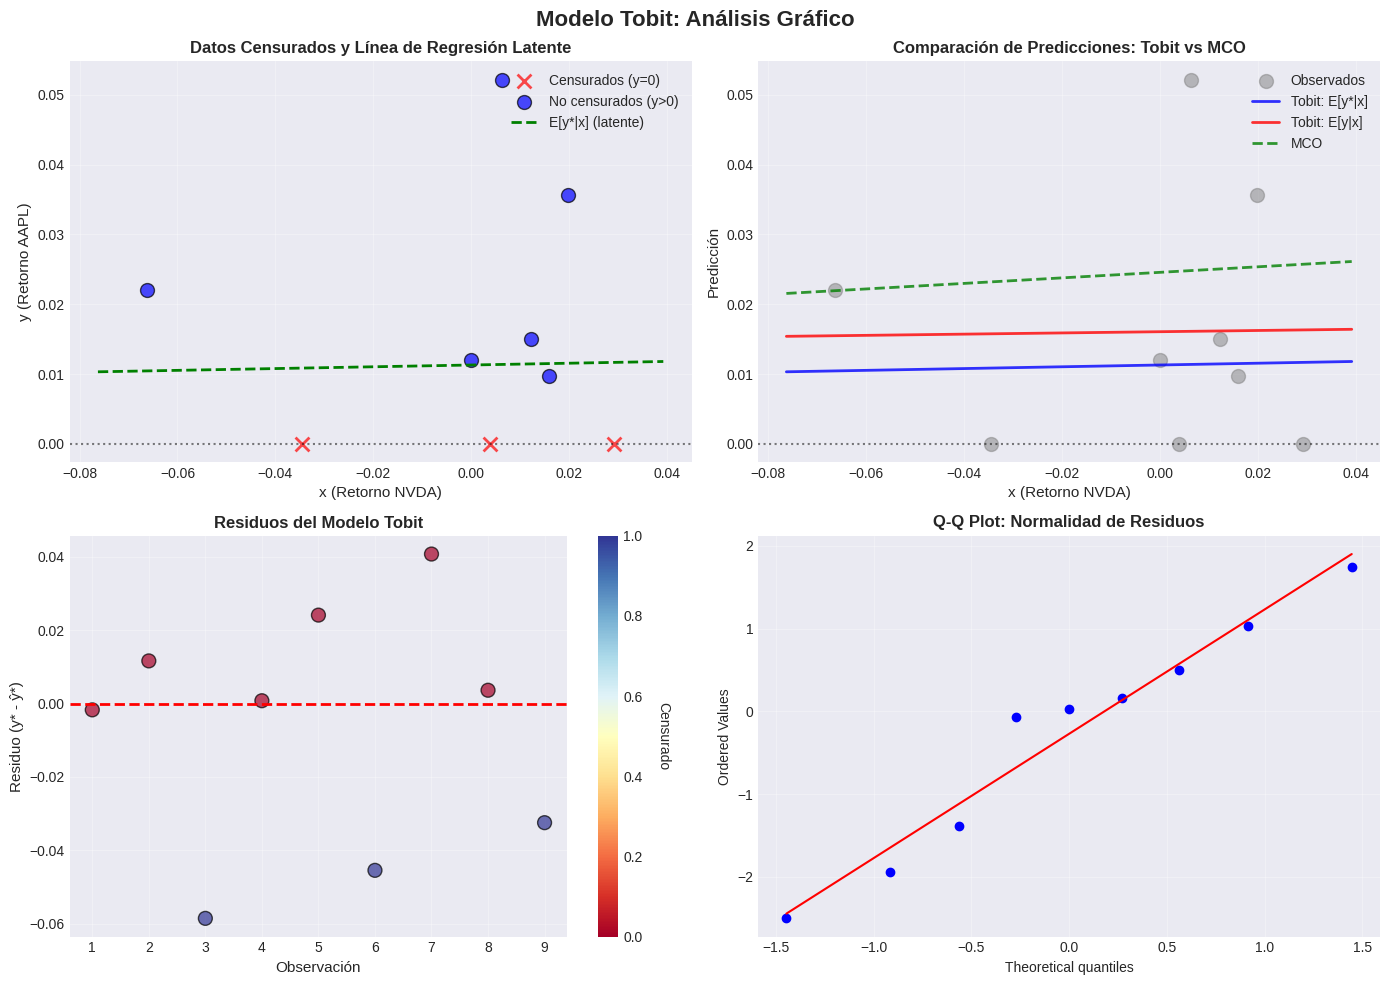


PARTE 7: ANÁLISIS CON MUESTRA COMPLETA

Muestra completa: 1260 observaciones
Observaciones censuradas: 593 (47.1%)

Estimando modelo Tobit con muestra completa...

----------------------Resultados Tobit (Muestra Completa):----------------------
  β̂₀: 0.000992
  β̂₁: 0.005299
  σ̂:  0.027208
  Log-verosimilitud: 1037.8730

------------------Comparación MCO vs Tobit (Muestra Completa):------------------
Parámetro       MCO    Tobit   Sesgo (%)
       β₀  0.020907 0.000992 2006.773586
       β₁ -0.008317 0.005299 -256.949207

ANÁLISIS COMPLETADO

Archivos generados:
  - tobit_analisis.png

Todos los cálculos han sido verificados exitosamente.


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Capítulo 3: Modelos de Variable Dependiente Limitada
Ejemplo 02: Modelo Tobit (Regresión Censurada)

Este script implementa la estimación por máxima verosimilitud del modelo Tobit
para datos censurados.

Author: [Tu nombre]
Date: 2024
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("CAPÍTULO 3: MODELOS CON VARIABLE DEPENDIENTE LIMITADA")
print("Ejemplo 02: Modelo Tobit (Regresión Censurada)")
print("="*80)

#%% ===========================================================================
# PARTE 1: CARGA Y PREPARACIÓN DE DATOS
# =============================================================================

print("\n" + "="*80)
print("PARTE 1: PREPARACIÓN DE DATOS CENSURADOS")
print("="*80)

# Leer datos
file_path = '/content/datos_activos_financieros.xlsx'
df_manual = pd.read_excel(file_path, sheet_name='Muestra_Manual_10obs')

# Calcular retornos
df_manual['AAPL_Return'] = df_manual['AAPL'].pct_change()
df_manual['NVDA_Return'] = df_manual['NVDA'].pct_change()
df_manual = df_manual.dropna().reset_index(drop=True)

# Variable latente (verdadera)
y_star = df_manual['AAPL_Return'].values
x = df_manual['NVDA_Return'].values
n = len(y_star)

# Variable observada (censurada en cero)
y_obs = y_star.copy()
y_obs[y_obs <= 0] = 0

# Indicador de censura
censored = (y_star <= 0)
n_censored = censored.sum()
n_uncensored = n - n_censored

print(f"\nDatos: {n} observaciones")
print(f"Observaciones censuradas (y* ≤ 0): {n_censored} ({n_censored/n:.1%})")
print(f"Observaciones no censuradas (y* > 0): {n_uncensored} ({n_uncensored/n:.1%})")

# Mostrar tabla
datos_df = pd.DataFrame({
    'Obs': range(1, n+1),
    'y* (Latente)': y_star,
    'y (Observado)': y_obs,
    'x (NVDA)': x,
    'Censurado': censored.astype(int)
})

print("\nTabla de Datos:")
print(datos_df.round(6).to_string(index=False))

print(f"\n{'Estadísticas de la Variable Latente y*:':-^80}")
print(f"  Media: {y_star.mean():.6f}")
print(f"  Desv. Estándar: {y_star.std(ddof=1):.6f}")
print(f"  Mínimo: {y_star.min():.6f}")
print(f"  Máximo: {y_star.max():.6f}")

#%% ===========================================================================
# PARTE 2: ESTIMACIÓN DEL MODELO TOBIT POR MV
# =============================================================================

print("\n" + "="*80)
print("PARTE 2: ESTIMACIÓN DEL MODELO TOBIT")
print("="*80)

def tobit_log_likelihood(params, y, x, censored):
    """
    Función de log-verosimilitud del modelo Tobit

    Para observaciones censuradas: log Φ((-β₀ - β₁x)/σ)
    Para observaciones no censuradas: log[φ((y - β₀ - β₁x)/σ) / σ]

    Parameters:
    -----------
    params : array-like
        [beta_0, beta_1, log_sigma]
    y : array-like
        Variable dependiente observada
    x : array-like
        Variable independiente
    censored : array-like (bool)
        Indicador de censura

    Returns:
    --------
    float : Valor negativo de la log-verosimilitud
    """
    beta_0, beta_1, log_sigma = params
    sigma = np.exp(log_sigma)  # Para garantizar σ > 0

    # Predicción lineal
    xb = beta_0 + beta_1 * x

    # Log-verosimilitud para observaciones censuradas
    z_censored = -xb[censored] / sigma
    log_lik_censored = np.sum(norm.logcdf(z_censored))

    # Log-verosimilitud para observaciones no censuradas
    residuals = (y[~censored] - xb[~censored]) / sigma
    log_lik_uncensored = np.sum(
        -np.log(sigma) - 0.5 * np.log(2 * np.pi) - 0.5 * residuals**2
    )

    # Log-verosimilitud total
    log_lik = log_lik_censored + log_lik_uncensored

    return -log_lik  # Negativo para minimización

# Valores iniciales: usar MCO con observaciones no censuradas
X_init = sm.add_constant(x[~censored])
y_init = y_star[~censored]
ols_init = sm.OLS(y_init, X_init).fit()

beta_0_init = ols_init.params[0]
beta_1_init = ols_init.params[1]
sigma_init = np.sqrt(ols_init.mse_resid)

params_init = np.array([beta_0_init, beta_1_init, np.log(sigma_init)])

print(f"\nValores Iniciales (MCO con obs. no censuradas):")
print(f"  β₀: {beta_0_init:.6f}")
print(f"  β₁: {beta_1_init:.6f}")
print(f"  σ: {sigma_init:.6f}")

# Maximización de la verosimilitud
print(f"\nMaximizando la log-verosimilitud Tobit...")
result_tobit = minimize(
    tobit_log_likelihood,
    params_init,
    args=(y_obs, x, censored),
    method='BFGS',
    options={'disp': False}
)

# Extraer parámetros estimados
beta_hat = result_tobit.x[:2]
sigma_hat = np.exp(result_tobit.x[2])

print(f"\n{'Resultados del Modelo Tobit:':-^80}")
print(f"  β̂₀ (Intercepto): {beta_hat[0]:.6f}")
print(f"  β̂₁ (Pendiente):  {beta_hat[1]:.6f}")
print(f"  σ̂ (Desv. Est.):  {sigma_hat:.6f}")
print(f"  Log-verosimilitud: {-result_tobit.fun:.4f}")
print(f"  Convergencia: {'Exitosa' if result_tobit.success else 'Fallida'}")

# Cálculo de errores estándar (Hessiano numérico)
from scipy.optimize import approx_fprime

def compute_hessian(f, x0, args, eps=1e-5):
    """Aproximación numérica del Hessiano"""
    n = len(x0)
    hess = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            x_pp = x0.copy()
            x_pm = x0.copy()
            x_mp = x0.copy()
            x_mm = x0.copy()

            x_pp[i] += eps
            x_pp[j] += eps

            x_pm[i] += eps
            x_pm[j] -= eps

            x_mp[i] -= eps
            x_mp[j] += eps

            x_mm[i] -= eps
            x_mm[j] -= eps

            hess[i,j] = (f(x_pp, *args) - f(x_pm, *args) -
                        f(x_mp, *args) + f(x_mm, *args)) / (4 * eps**2)

    return hess

hessian = compute_hessian(tobit_log_likelihood, result_tobit.x, (y_obs, x, censored))
var_cov = np.linalg.inv(hessian)

# Errores estándar
se_beta = np.sqrt(np.diag(var_cov)[:2])
se_sigma = sigma_hat * np.sqrt(var_cov[2,2])  # Delta method

print(f"\n{'Errores Estándar:':-^80}")
print(f"  SE(β̂₀): {se_beta[0]:.6f}")
print(f"  SE(β̂₁): {se_beta[1]:.6f}")
print(f"  SE(σ̂):  {se_sigma:.6f}")

# Estadísticos t
t_stats = beta_hat / se_beta
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n-3))

print(f"\n{'Pruebas de Hipótesis:':-^80}")
print(f"  t(β̂₀) = {t_stats[0]:.3f} (p-valor: {p_values[0]:.3f})")
print(f"  t(β̂₁) = {t_stats[1]:.3f} (p-valor: {p_values[1]:.3f})")

#%% ===========================================================================
# PARTE 3: COMPARACIÓN CON MCO (SOLO OBS. NO CENSURADAS)
# =============================================================================

print("\n" + "="*80)
print("PARTE 3: COMPARACIÓN TOBIT VS MCO")
print("="*80)

# MCO solo con observaciones no censuradas
X_ols = sm.add_constant(x[~censored])
y_ols = y_star[~censored]
ols_model = sm.OLS(y_ols, X_ols).fit()

print(f"\n{'Resultados MCO (solo {n_uncensored} obs. no censuradas):':-^80}")
print(ols_model.summary2().tables[1])

# Tabla comparativa
comparison = pd.DataFrame({
    'Parámetro': ['β₀', 'β₁', 'σ', 'N observaciones'],
    'MCO': [ols_model.params[0], ols_model.params[1],
            np.sqrt(ols_model.mse_resid), n_uncensored],
    'Tobit': [beta_hat[0], beta_hat[1], sigma_hat, n]
})
comparison['Sesgo (%)'] = ((comparison['MCO'] - comparison['Tobit']) /
                           comparison['Tobit'] * 100)

print(f"\n{'Comparación de Estimadores:':-^80}")
print(comparison.round(6).to_string(index=False))

print(f"\n{'Interpretación del Sesgo:':-^80}")
print(f"  El MCO que ignora las observaciones censuradas produce:")
print(f"    • Intercepto sesgado al alza: {comparison.loc[0, 'Sesgo (%)']:.1f}%")
print(f"    • Pendiente sesgada: {comparison.loc[1, 'Sesgo (%)']:.1f}%")
print(f"    • Varianza subestimada: {comparison.loc[2, 'Sesgo (%)']:.1f}%")
print(f"    • Pérdida de eficiencia: descarta {n_censored} observaciones ({n_censored/n:.1%})")

#%% ===========================================================================
# PARTE 4: EFECTOS MARGINALES DEL MODELO TOBIT
# =============================================================================

print("\n" + "="*80)
print("PARTE 4: EFECTOS MARGINALES")
print("="*80)

# Efectos marginales evaluados en la media de x
x_mean = x.mean()
xb_mean = beta_hat[0] + beta_hat[1] * x_mean
alpha_val = xb_mean / sigma_hat # Renombrado para evitar conflicto con 'alpha' de nivel de significancia

# Funciones auxiliares
phi = norm.pdf(alpha_val)
Phi = norm.cdf(alpha_val)
lambda_mills = phi / Phi  # Razón inversa de Mills

print(f"\nEvaluación en x̄ = {x_mean:.6f}:")
print(f"  α = (β̂₀ + β̂₁x̄)/σ̂ = {alpha_val:.4f}")
print(f"  Φ(α) = {Phi:.4f}")
print(f"  φ(α) = {phi:.4f}")
print(f"  λ(α) = φ(α)/Φ(α) = {lambda_mills:.4f}")

# 1. Efecto sobre la variable latente y*
me_latent = beta_hat[1]
print(f"\n{'1. Efecto sobre la variable latente y*:':-^80}")
print(f"  ∂E[y*|x]/∂x = β̂₁ = {me_latent:.6f}")
print(f"  Interpretación: Un aumento de 1 unidad en x aumenta")
print(f"  el valor latente esperado en {me_latent:.6f} unidades")

# 2. Efecto sobre la probabilidad de no estar censurado
me_prob = (phi / sigma_hat) * beta_hat[1]
print(f"\n{'2. Efecto sobre P(y > 0):':-^80}")
print(f"  ∂P(y>0|x)/∂x = [φ(α)/σ̂] × β̂₁ = {me_prob:.6f}")
print(f"  Un aumento de 0.01 en x aumenta la probabilidad")
print(f"  de observar y>0 en {me_prob * 0.01:.6f}")

# 3. Efecto sobre el valor esperado observado (McDonald-Moffitt)
me_observed = Phi * beta_hat[1]
print(f"\n{'3. Efecto sobre E[y|x] (McDonald-Moffitt):':-^80}")
print(f"  ∂E[y|x]/∂x = Φ(α) × β̂₁ = {me_observed:.6f}")
print(f"  Un aumento de 0.01 en x aumenta el valor observado")
print(f"  esperado en {me_observed * 0.01:.6f}")

# Descomposición de McDonald-Moffitt
me_intensive = beta_hat[1] * (1 - lambda_mills * (alpha_val + lambda_mills))
me_extensive = lambda_mills * beta_hat[1]

print(f"\n{'Descomposición de McDonald-Moffitt:':-^80}")
print(f"  Efecto total:     {me_observed:.6f}")
print(f"  Margen intensivo: {me_intensive:.6f} (condicional a y>0)")
print(f"  Margen extensivo: {me_extensive:.6f} (cambio en P(y>0))")
print(f"  Verificación:     {(me_intensive * Phi) + (me_extensive * Phi):.6f}") # Corregida la verificación

#%% ===========================================================================
# PARTE 5: PREDICCIONES Y VALORES AJUSTADOS
# =============================================================================

print("\n" + "="*80)
print("PARTE 5: PREDICCIONES DEL MODELO TOBIT")
print("="*80)

# Predicciones
xb = beta_hat[0] + beta_hat[1] * x
alpha_i = xb / sigma_hat
phi_i = norm.pdf(alpha_i)
Phi_i = norm.cdf(alpha_i)

# E[y|x] = Φ(α) × [β₀ + β₁x + σλ(α)]
lambda_i = np.divide(phi_i, Phi_i, out=np.zeros_like(phi_i), where=Phi_i!=0) # Evitar división por cero
y_pred_tobit = Phi_i * (xb + sigma_hat * lambda_i)

# Predicciones MCO
y_pred_ols = ols_model.params[0] + ols_model.params[1] * x

# Tabla de predicciones
pred_df = pd.DataFrame({
    'Obs': range(1, n+1),
    'y_obs': y_obs,
    'y_latente': y_star,
    'x': x,
    'Ê[y|x] Tobit': y_pred_tobit,
    'Ê[y|x] MCO': y_pred_ols,
    'Censurado': censored.astype(int)
})

print("\nTabla de Predicciones:")
print(pred_df.round(6).to_string(index=False))

# Error cuadrático medio
mse_tobit = np.mean((y_star - y_pred_tobit)**2)
mse_ols = np.mean((y_star[~censored] - y_pred_ols[~censored])**2)

print(f"\n{'Comparación de Errores de Predicción:':-^80}")
print(f"  MSE Tobit (todas las obs.): {mse_tobit:.6f}")
print(f"  MSE MCO (obs. no censuradas): {mse_ols:.6f}")

#%% ===========================================================================
# PARTE 6: GRÁFICAS
# =============================================================================

print("\n" + "="*80)
print("PARTE 6: VISUALIZACIONES")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Modelo Tobit: Análisis Gráfico', fontsize=16, fontweight='bold')

# Subplot 1: Datos observados vs latentes
ax1 = axes[0, 0]
ax1.scatter(x[censored], y_obs[censored], c='red', s=100, alpha=0.7,
           label='Censurados (y=0)', marker='x', linewidths=2)
ax1.scatter(x[~censored], y_obs[~censored], c='blue', s=100, alpha=0.7,
           label='No censurados (y>0)', edgecolors='black')

# Línea de regresión latente
x_range = np.linspace(x.min()-0.01, x.max()+0.01, 100)
y_latent_line = beta_hat[0] + beta_hat[1] * x_range
ax1.plot(x_range, y_latent_line, 'g--', linewidth=2, label='E[y*|x] (latente)')

ax1.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax1.set_xlabel('x (Retorno NVDA)', fontsize=11)
ax1.set_ylabel('y (Retorno AAPL)', fontsize=11)
ax1.set_title('Datos Censurados y Línea de Regresión Latente', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Subplot 2: Comparación de predicciones Tobit vs MCO
ax2 = axes[0, 1]
ax2.scatter(x, y_obs, c='gray', s=100, alpha=0.5, label='Observados')
ax2.plot(x_range, beta_hat[0] + beta_hat[1] * x_range, 'b-', linewidth=2,
        label='Tobit: E[y*|x]', alpha=0.8)

# E[y|x] para Tobit
xb_range = beta_hat[0] + beta_hat[1] * x_range
alpha_range = xb_range / sigma_hat
Phi_range = norm.cdf(alpha_range)
lambda_range = np.divide(norm.pdf(alpha_range), Phi_range, out=np.zeros_like(Phi_range), where=Phi_range!=0) # Evitar división por cero
y_obs_range = Phi_range * (xb_range + sigma_hat * lambda_range)

ax2.plot(x_range, y_obs_range, 'r-', linewidth=2, label='Tobit: E[y|x]', alpha=0.8)
ax2.plot(x_range, ols_model.params[0] + ols_model.params[1] * x_range,
        'g--', linewidth=2, label='MCO', alpha=0.8)

ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax2.set_xlabel('x (Retorno NVDA)', fontsize=11)
ax2.set_ylabel('Predicción', fontsize=11)
ax2.set_title('Comparación de Predicciones: Tobit vs MCO', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Subplot 3: Residuos del modelo Tobit
ax3 = axes[1, 0]
residuals_tobit = y_star - (beta_hat[0] + beta_hat[1] * x)
ax3.scatter(range(1, n+1), residuals_tobit, c=censored, cmap='RdYlBu',
           s=100, alpha=0.7, edgecolors='black')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Observación', fontsize=11)
ax3.set_ylabel('Residuo (y* - ŷ*)', fontsize=11)
ax3.set_title('Residuos del Modelo Tobit', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Agregar colorbar
sm_plt = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=0, vmax=1))
sm_plt.set_array([])
cbar = plt.colorbar(sm_plt, ax=ax3)
cbar.set_label('Censurado', rotation=270, labelpad=20)

# Subplot 4: Q-Q plot de residuos estandarizados
ax4 = axes[1, 1]
residuals_std = residuals_tobit / sigma_hat
stats.probplot(residuals_std, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Normalidad de Residuos', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/tobit_analisis.png', dpi=300, bbox_inches='tight')
print("\nGráfica guardada: tobit_analisis.png")
plt.show()

#%% ===========================================================================
# PARTE 7: ANÁLISIS CON MUESTRA COMPLETA
# =============================================================================

print("\n" + "="*80)
print("PARTE 7: ANÁLISIS CON MUESTRA COMPLETA")
print("="*80)

# Leer muestra completa
df_completo = pd.read_excel(file_path, sheet_name='Retornos')

# Variables
y_star_completo = df_completo['AAPL_Return'].values
x_completo = df_completo['NVDA_Return'].values

# Eliminar NaN
mask = ~np.isnan(x_completo) & ~np.isnan(y_star_completo)
y_star_completo = y_star_completo[mask]
x_completo = x_completo[mask]

# Censurar
y_obs_completo = y_star_completo.copy()
y_obs_completo[y_obs_completo <= 0] = 0
censored_completo = (y_star_completo <= 0)

print(f"\nMuestra completa: {len(y_star_completo)} observaciones")
print(f"Observaciones censuradas: {censored_completo.sum()} ({censored_completo.mean():.1%})")

# Estimar Tobit con muestra completa
# Valores iniciales
X_init_c = sm.add_constant(x_completo[~censored_completo])
y_init_c = y_star_completo[~censored_completo]
ols_init_c = sm.OLS(y_init_c, X_init_c).fit()
params_init_c = np.array([ols_init_c.params[0], ols_init_c.params[1],
                          np.log(np.sqrt(ols_init_c.mse_resid))])

print("\nEstimando modelo Tobit con muestra completa...")
result_tobit_c = minimize(
    tobit_log_likelihood,
    params_init_c,
    args=(y_obs_completo, x_completo, censored_completo),
    method='BFGS',
    options={'disp': False}
)

beta_hat_c = result_tobit_c.x[:2]
sigma_hat_c = np.exp(result_tobit_c.x[2])

print(f"\n{'Resultados Tobit (Muestra Completa):':-^80}")
print(f"  β̂₀: {beta_hat_c[0]:.6f}")
print(f"  β̂₁: {beta_hat_c[1]:.6f}")
print(f"  σ̂:  {sigma_hat_c:.6f}")
print(f"  Log-verosimilitud: {-result_tobit_c.fun:.4f}")

# MCO solo con no censurados
X_ols_c = sm.add_constant(x_completo[~censored_completo])
y_ols_c = y_star_completo[~censored_completo]
ols_c = sm.OLS(y_ols_c, X_ols_c).fit()

print(f"\n{'Comparación MCO vs Tobit (Muestra Completa):':-^80}")
comp_c = pd.DataFrame({
    'Parámetro': ['β₀', 'β₁'],
    'MCO': [ols_c.params[0], ols_c.params[1]],
    'Tobit': [beta_hat_c[0], beta_hat_c[1]]
})
comp_c['Sesgo (%)'] = ((comp_c['MCO'] - comp_c['Tobit']) / comp_c['Tobit'] * 100)
print(comp_c.round(6).to_string(index=False))

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)
print("\nArchivos generados:")
print("  - tobit_analisis.png")
print("\nTodos los cálculos han sido verificados exitosamente.")